In [1]:
import os
from os.path import join, abspath

import sys
sys.path.append(abspath('..'))
import pandas as pd
import numpy as np

from utils import get_dataset, get_target, Preprocessor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from warnings import simplefilter
simplefilter("ignore")

RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)

EPS = 1e-3


DATA_PATH = join(os.getcwd(), '..', 'data', 'events')

## 1. Load Dataset

In [2]:
event_keys = os.listdir(DATA_PATH)
event_keys = [ek for ek in event_keys if ek.isdigit()]
event_dirs = [join(DATA_PATH, ek) for ek in event_keys]
len(event_dirs)

5

In [3]:
teams, players = get_dataset(event_dirs)
teams = teams.dropna()
players = players.dropna()

Player with id=15573 has no matching team_id.
Player with id=16848 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=21816 has no matching team_id.
Player with id=18163 has no matching team_id.
Player with id=21217 has no matching team_id.
Player with id=13618 has no matching team_id.
Player with id=20170 has no matching team_id.
Player with id=13602 has no matching team_id.
Player with id=11777 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=19164 has no matching team_id.


In [4]:
teams

,has_roster_change,world_ranking,points,avg_place,winrate,avg_match_intensity,avg_win_intensity,avg_loss_intensity,winstreak,matches_played,...,wr_target,team_id,team_name,is_lan,is_qual,prize_pool,start_at,ends_at,duration,event_id
0,False,20,117,4.87500,0.619048,1.160991,1.434571,0.716424,4,21,...,0.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
1,False,20,117,4.80000,0.512821,1.373098,2.027451,0.684306,0,39,...,0.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
2,True,20,117,5.28125,0.591837,1.453861,1.989617,0.677014,0,49,...,0.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
3,False,20,117,4.87500,0.500000,1.062761,1.409098,0.716424,2,16,...,0.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
4,False,20,117,14.50000,0.600000,0.977839,1.183785,0.668919,1,5,...,0.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,False,3,709,3.50000,0.500000,1.106838,1.444444,0.769231,0,2,...,0.666667,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
476,False,3,709,3.75000,0.500000,1.394595,2.022222,0.766968,0,4,...,0.666667,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
477,False,3,709,9.00000,0.250000,1.010977,1.444444,0.866488,0,4,...,0.666667,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
478,False,3,709,3.75000,0.500000,1.394595,2.022222,0.766968,0,4,...,0.666667,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148


In [5]:
players

,rating,dpr,kast,impact,adr,kpr,total_kills,hs,kd,gdr,...,player_name,expected_pts_target,player_id,is_lan,is_qual,prize_pool,start_at,ends_at,duration,event_id
0,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.00,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
1,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.00,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
2,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.00,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
3,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.00,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
4,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.00,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36783,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36784,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36785,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36786,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148


In [6]:
len(teams), len(players)

(427, 32521)

## 2. Modelling

In [7]:
event_keys

['7755', '7440', '7437', '6976', '7148']

In [8]:
train_events = [7755, 7440, 7437, 6976]
test_events = [int(ek) for ek in event_keys if int(ek) not in train_events]

### 2.1. Teams model

In [9]:
target_col = ["wr_target"]

drop_cols = ["start_time", "end_time", "start_at", "ends_at", "event_id", "team_id",
             "event_fil", "team_name"]
drop_cols += [f"player_id_{i + 1}" for i in range(5)]
drop_cols += target_col

cat_cols = ["ranking_fil"]
bin_cols = ["has_roster_change", "is_lan", "is_qual"]

teams[bin_cols] = teams[bin_cols].astype(np.float64)
teams[target_col] = teams[target_col].astype(np.float64)

In [10]:
train = teams[teams.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = teams[teams.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col]

In [11]:
len(X_train), len(X_train.columns)

(331, 15)

In [12]:
team_pipe = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=10))
])

In [13]:
def logit(x, clip=5):
    logits = np.log(x / (1 - x + EPS) + EPS)
    return np.clip(logits, a_min=-clip, a_max=clip)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
logit(y_train).head(10)

,wr_target
0,-5.000000
1,1.784952
2,1.784952
3,-1.096945
4,0.508764
5,-0.000997
6,0.286103
7,1.603657
8,-0.692645
9,-5.000000


In [15]:
team_pipe.fit(X_train, logit(y_train))  # winrate is probability
y_preds = sigmoid(team_pipe.predict(X_test))
mean_squared_error(y_test, y_preds)

0.03755105916613146

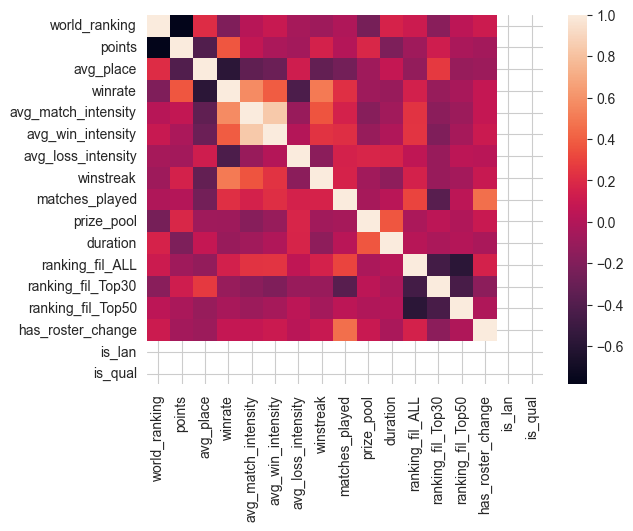

In [16]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

In [17]:
n = 10

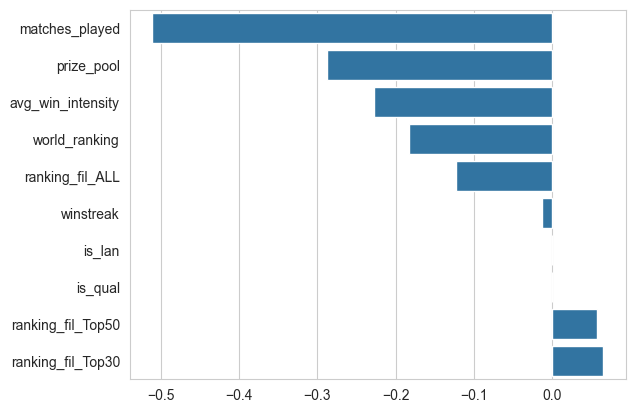

In [18]:
idx = np.argsort(team_pipe["estimator"].coef_.ravel())[:n]
sns.barplot(x=team_pipe["estimator"].coef_.ravel()[idx],
            y=team_pipe["preprocessor"].features.ravel()[idx]);

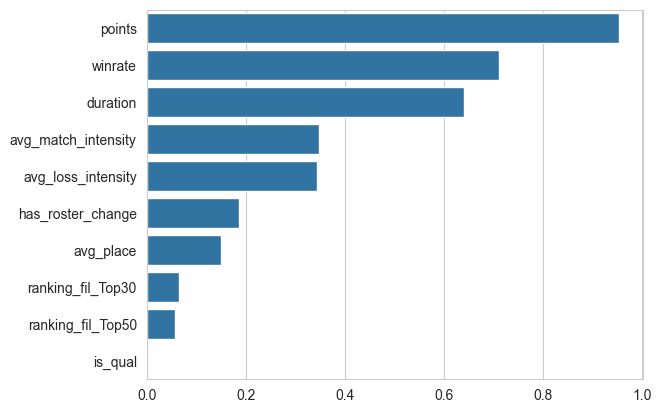

In [19]:
idx = np.argsort(team_pipe["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=team_pipe["estimator"].coef_.ravel()[idx],
            y=team_pipe["preprocessor"].features.ravel()[idx]);

По реальному винрейту:

In [20]:
final_team = test[["team_id", "team_name"]]
final_team["wr_target"] = y_test
final_team["pred_wr"] = y_preds
final_team = final_team.groupby(["team_id"]).max()
final_team = final_team.sort_values(["wr_target"], ascending=False)
final_team.head(10)

,team_name,wr_target,pred_wr
team_id,,,
4494,mouz,0.750000,0.718181
4608,natus-vincere,0.750000,0.534278
7020,spirit,0.750000,0.922141
9565,vitality,0.666667,0.729053
6667,faze,0.625000,0.825008
5752,cloud9,0.600000,0.435578
11251,eternal-fire,0.600000,0.443707
5995,g2,0.571429,0.585399
4773,pain,0.400000,0.090844


По предсказанному винрейту:

In [21]:
final_team.sort_values(["pred_wr"], ascending=False).head(10)

,team_name,wr_target,pred_wr
team_id,,,
7020,spirit,0.750000,0.922141
6667,faze,0.625000,0.825008
9565,vitality,0.666667,0.729053
4494,mouz,0.750000,0.718181
5995,g2,0.571429,0.585399
4608,natus-vincere,0.750000,0.534278
7175,heroic,0.250000,0.455237
5005,complexity,0.400000,0.444299
11251,eternal-fire,0.600000,0.443707


### Замечание

Без минмакс маппинга результаты ранжирования другие.

### 2.2. Players model

In [22]:
target_col = ["expected_pts_target"]

drop_cols = ["start_time", "end_time", "start_at", "ends_at", "event_id", "player_id",
             "player_name",
             "duration", "maps_played", "kpr"]  # correlated
drop_cols += [f"team_id"]
drop_cols += target_col

cat_cols = ["event_fil", "ranking_fil"]
bin_cols = ["is_lan", "is_qual", "is_awp"]

players[bin_cols] = players[bin_cols].astype(np.float64)
players[target_col] = players[target_col].astype(np.float64)
players = players.dropna()

In [23]:
train = players[players.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = players[players.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col].astype(np.float64)
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col].astype(np.float64)

In [24]:
len(X_train), len(X_train.columns)

(24429, 20)

In [25]:
player_pipeline = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=1))
])

In [26]:
player_pipeline.fit(X_train, y_train)
y_preds = player_pipeline.predict(X_test)
mean_squared_error(y_test, y_preds)

32.94090133413917

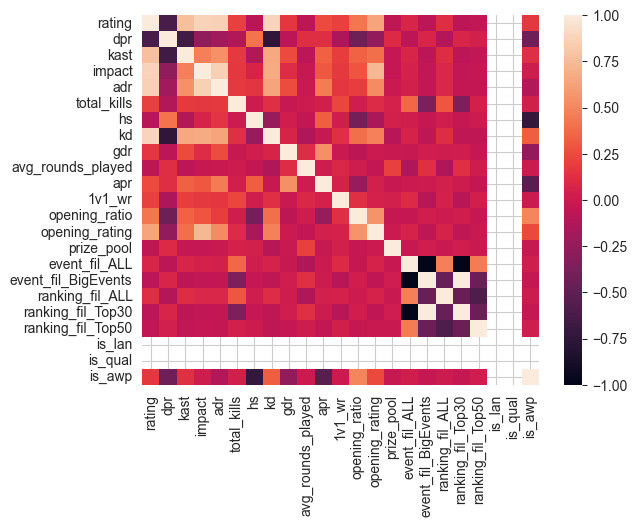

In [27]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

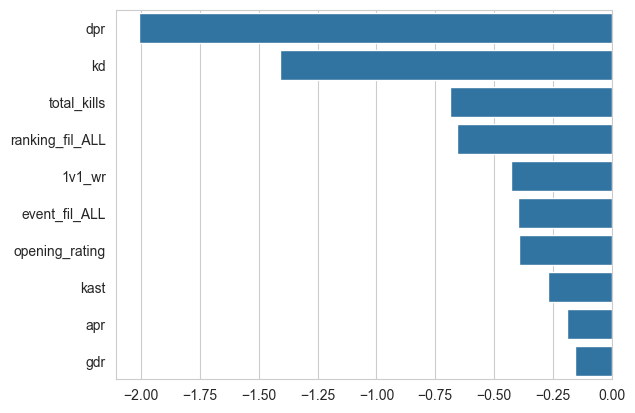

In [28]:
idx = np.argsort(player_pipeline["estimator"].coef_.ravel())[:n]
sns.barplot(x=player_pipeline["estimator"].coef_.ravel()[idx],
            y=player_pipeline["preprocessor"].features.ravel()[idx]);

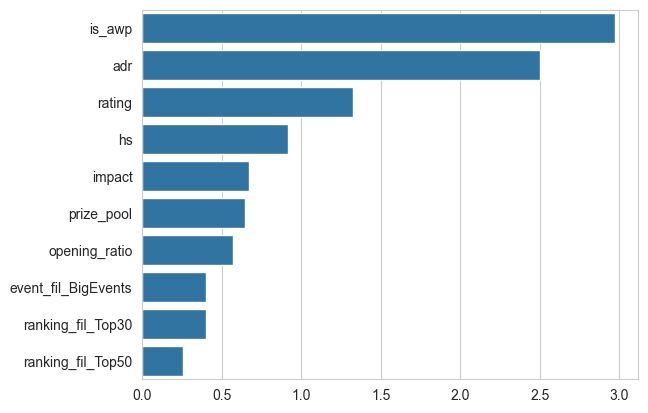

In [29]:
idx = np.argsort(player_pipeline["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=player_pipeline["estimator"].coef_.ravel()[idx],
            y=player_pipeline["preprocessor"].features.ravel()[idx]);

Обычная регрессия выдавала взрывные коэффициенты на фильтры.

По реальным поинтам:

In [30]:
final_player = test[["player_id", "team_id", "player_name"]]
final_player[["player_id", "team_id"]] = final_player[["player_id", "team_id"]].astype(np.int32)
final_player["pts_target"] = y_test
final_player["pred_pts"] = y_preds
final_player = final_player.groupby(["player_id"]).max()
final_player = final_player.sort_values(["pts_target"], ascending=False)
final_player.head(10)

,team_id,player_name,pts_target,pred_pts
player_id,,,,
21167,7020,donk,16.750000,26.485106
19230,5995,m0nesy,15.000000,17.489216
18072,4494,torzsi,13.000000,11.034981
13666,4494,brollan,11.750000,14.451618
18850,4494,jimpphat,11.000000,11.802926
16920,7020,sh1ro,11.000000,19.882138
16555,5752,ax1le,10.200000,17.303355
19206,4608,jl,9.500000,11.915858
7938,11251,xantares,9.200000,12.062861


По предсказанным поинтам:

In [31]:
final_player.sort_values(["pred_pts"], ascending=False).head(10)

,team_id,player_name,pts_target,pred_pts
player_id,,,,
21167,7020,donk,16.750000,26.485106
8738,5005,elige,0.000000,21.325515
16920,7020,sh1ro,11.000000,19.882138
13776,5378,jame,7.200000,17.911860
19230,5995,m0nesy,15.000000,17.489216
16555,5752,ax1le,10.200000,17.303355
16947,5752,perfecto,3.400000,17.275997
3972,5995,hunter,5.285714,16.622810
11893,9565,zywoo,6.166667,15.680290


## 3. Results

По реальному таргету:

In [32]:
final = final_player.join(final_team, on="team_id")
final["target"] = get_target(final.pts_target, final.wr_target)
final["pred_target"] = get_target(final.pred_pts, final.pred_wr)
final = final[["target", "pred_target", "team_name", "player_name"]]
final = final.sort_values(["target"], ascending=False)
final.head(10)

,target,pred_target,team_name,player_name
player_id,,,,
21167,20.500000,31.784375,spirit,donk
19230,17.142857,19.757811,g2,m0nesy
18072,16.750000,14.498614,mouz,torzsi
13666,15.500000,17.915251,mouz,brollan
18850,14.750000,15.266559,mouz,jimpphat
16920,14.750000,25.181407,spirit,sh1ro
19206,13.250000,13.724357,natus-vincere,jl
16555,12.600000,18.223556,cloud9,ax1le
7938,11.600000,13.056223,eternal-fire,xantares


По предсказанному таргету:

In [33]:
final = final.sort_values(["pred_target"], ascending=False)
final.head(10)

,target,pred_target,team_name,player_name
player_id,,,,
21167,20.500000,31.784375,spirit,donk
16920,14.750000,25.181407,spirit,sh1ro
8738,0.600000,22.324203,complexity,elige
19230,17.142857,19.757811,g2,m0nesy
11893,9.166667,19.241763,vitality,zywoo
20423,8.250000,18.978447,spirit,zont1x
3972,7.428571,18.891405,g2,hunter
16555,12.600000,18.223556,cloud9,ax1le
16947,5.800000,18.196198,cloud9,perfecto
